# Preprocesamiento y Creación de Modelos de clasificación

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from gensim.models.doc2vec import TaggedDocument
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

df = pd.read_csv('https://raw.githubusercontent.com/lihkir/Data/main/spam_text_class.csv',delimiter=',',encoding='latin-1')

df = df[['Category','Message']]

df = df[pd.notnull(df['Message'])]

# quitar etiquetas html

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

df['Message'] = df['Message'].apply(cleanText)

train_test split

In [3]:
max_fatures = 500000

MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)

X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

Y = pd.get_dummies(df['Category']).values

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)


## SMOTE

In [4]:
from imblearn.over_sampling import SMOTE

# Crear una instancia de SMOTE
smote = SMOTE(random_state=42)

y_for_smote = np.argmax(y_train, axis=1)

# Aplicar SMOTE al conjunto de entrenamiento
X_train_smote, y_for_smote = smote.fit_resample(X_train, y_train)

# Get unique values in the array
unique_values = np.unique(y_for_smote)

# Initialize one-hot encoded array with zeros
y_train_smote = np.zeros((len(y_for_smote), len(unique_values)))

# Fill in the one-hot array based on the original binary array
for i, value in enumerate(y_for_smote):

    y_train_smote[i, np.where(unique_values == value)] = 1

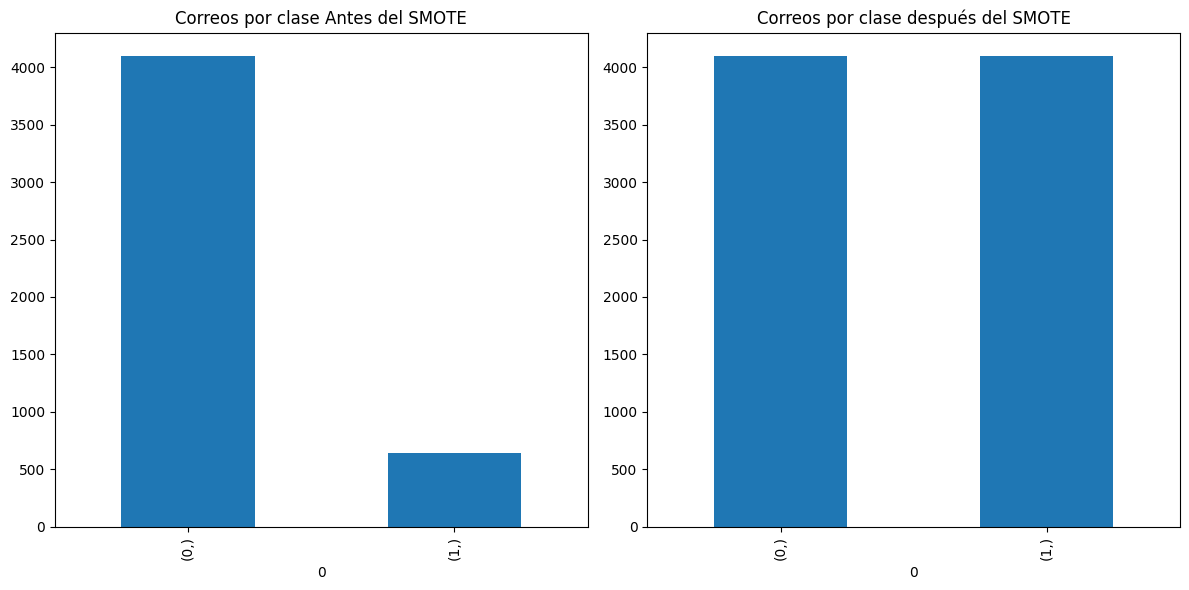

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Chart 1
plt.subplot(1, 2, 1)
pd.DataFrame(np.argmax(y_train, axis=1).astype(str)).value_counts().plot(kind='bar', title='Correos por clase Antes del SMOTE')

# Chart 2
plt.subplot(1, 2, 2)
pd.DataFrame(np.argmax(y_train_smote, axis=1).astype(str)).value_counts().plot(kind='bar', title='Correos por clase después del SMOTE')

plt.tight_layout()  # To ensure proper spacing between subplots
plt.show()

## LSTM

In [6]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)

d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 358315.46it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 357137.99it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 529311.76it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 354601.53it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 554272.54it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 357821.62it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 356838.03it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 345035.11it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 356245.03it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 694026.01it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 356489.60it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 694665.62it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 356707.29it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 355443.00it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 345290.04it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<?, ?it/s]

  0%|                                                                                         | 0/5571 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 356266.75it/s]

Numero de palabras totales que queda en vector de embeddings

In [7]:
len(d2v_model.wv.index_to_key)

9363

top 10 parabras mas similares a 'urgent'

In [8]:
d2v_model.wv.most_similar(positive=['urgent'], topn=10)

[('yupz', 0.7874127626419067),
 ('aint', 0.7725856900215149),
 ('11mths+', 0.748444676399231),
 ('reserve', 0.7330030202865601),
 ('09061213237', 0.7013347744941711),
 ('07046744435', 0.6886118054389954),
 ('08719181503', 0.6700058579444885),
 ('princes', 0.6641163229942322),
 ('07', 0.6638977527618408),
 ('went', 0.6551580429077148)]

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers.legacy import Adam

# matriz de 9363 x 20
embedding_matrix = np.zeros((len(d2v_model.wv.index_to_key)+ 1, 20))

model = Sequential()

model.add(Embedding(len(d2v_model.wv.index_to_key)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

model.add(LSTM(50,return_sequences=False))

model.add(Dense(2,activation="softmax"))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 50, 20)            187280    


 lstm (LSTM)                 (None, 50)                14200     


 dense (Dense)               (None, 2)                 102       


Total params: 201,582


Trainable params: 201,582


Non-trainable params: 0


_________________________________________________________________


In [10]:
model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics = ['accuracy'])

batch_size = 32

history = model.fit(X_train, y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50


148/148 - 8s - loss: 0.2730 - accuracy: 0.9158 - 8s/epoch - 57ms/step


Epoch 2/50


148/148 - 5s - loss: 0.0571 - accuracy: 0.9869 - 5s/epoch - 34ms/step


Epoch 3/50


148/148 - 5s - loss: 0.0251 - accuracy: 0.9943 - 5s/epoch - 34ms/step


Epoch 4/50


148/148 - 5s - loss: 0.0135 - accuracy: 0.9975 - 5s/epoch - 33ms/step


Epoch 5/50


148/148 - 5s - loss: 0.0070 - accuracy: 0.9983 - 5s/epoch - 34ms/step


Epoch 6/50


27/27 [==============================] - 1s 11ms/step
Accuracy: 0.99
Precision: 0.98
Recall: 0.93
F1 Score: 0.96
AUC: 0.97


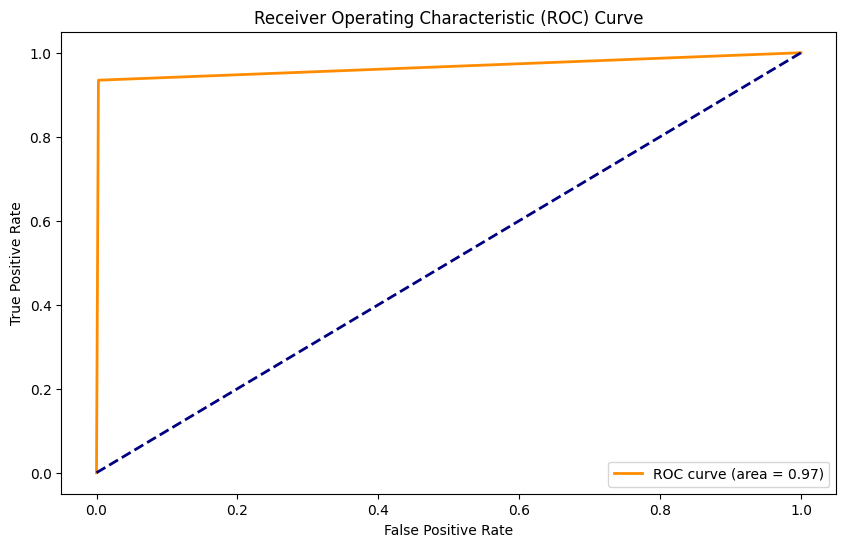

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

y_pred = model.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

y_test = y_test[:, 1].astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## LSTM con SMOTE

In [12]:
# matriz de 9363 x 20
embedding_matrix = np.zeros((len(d2v_model.wv.index_to_key)+ 1, 20))

model_2 = Sequential()

model_2.add(Embedding(len(d2v_model.wv.index_to_key)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

model_2.add(LSTM(50,return_sequences=False))

model_2.add(Dense(2,activation="softmax"))

model_2.compile(optimizer=Adam(),loss="binary_crossentropy",metrics = ['accuracy'])

batch_size = 32

history_2 = model_2.fit(X_train_smote, y_train_smote, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
256/256 - 8s - loss: 0.3630 - accuracy: 0.8361 - 8s/epoch - 33ms/step
Epoch 2/50
256/256 - 6s - loss: 0.1362 - accuracy: 0.9559 - 6s/epoch - 23ms/step
Epoch 3/50
256/256 - 6s - loss: 0.0779 - accuracy: 0.9779 - 6s/epoch - 23ms/step
Epoch 4/50
256/256 - 6s - loss: 0.0452 - accuracy: 0.9878 - 6s/epoch - 23ms/step
Epoch 5/50
256/256 - 6s - loss: 0.0274 - accuracy: 0.9932 - 6s/epoch - 23ms/step
Epoch 6/50
256/256 - 6s - loss: 0.0188 - accuracy: 0.9951 - 6s/epoch - 22ms/step
Epoch 7/50
256/256 - 5s - loss: 0.0126 - accuracy: 0.9963 - 5s/epoch - 21ms/step
Epoch 8/50
256/256 - 5s - loss: 0.0063 - accuracy: 0.9982 - 5s/epoch - 21ms/step
Epoch 9/50
256/256 - 5s - loss: 0.0053 - accuracy: 0.9985 - 5s/epoch - 21ms/step
Epoch 10/50
256/256 - 5s - loss: 0.0033 - accuracy: 0.9990 - 5s/epoch - 21ms/step
Epoch 11/50
256/256 - 5s - loss: 0.0037 - accuracy: 0.9991 - 5s/epoch - 21ms/step
Epoch 12/50
256/256 - 5s - loss: 0.0043 - accuracy: 0.9989 - 5s/epoch - 21ms/step
Epoch 13/50
256/256 - 5s 

27/27 [==============================] - 1s 11ms/step
Accuracy: 0.91
Precision: 0.58
Recall: 0.95
F1 Score: 0.72
AUC: 0.93


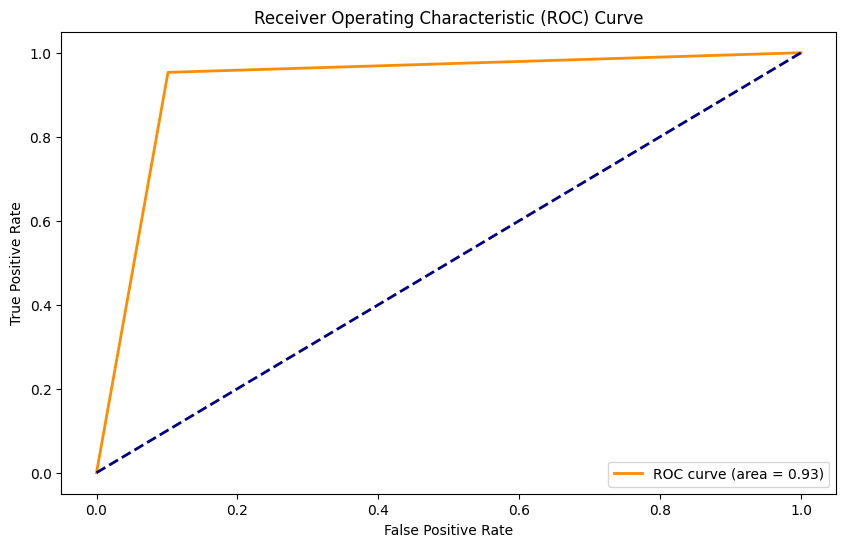

In [13]:
y_pred = model_2.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## KNN

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score

# Define the kNN classifier
knn_classifier = KNeighborsClassifier()

# Define the hyperparameters and their possible values
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

# Create a F1 scorer for grid search
f1_scorer = make_scorer(f1_score)

# Create GridSearchCV object
grid_search = GridSearchCV(knn_classifier, param_grid, scoring=f1_scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_knn_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_knn_model.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

# Calculate F1 Score on the test set
f1score = f1_score(y_test, y_pred)
print(f'F1 Score on Test Set: {f1score:.2f}')

Best Hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
F1 Score on Test Set: 0.48


In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Create a kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='uniform')

# Train the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn_classifier.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

Accuracy: 0.88
Precision: 0.55
Recall: 0.43
F1 Score: 0.48
AUC: 0.69


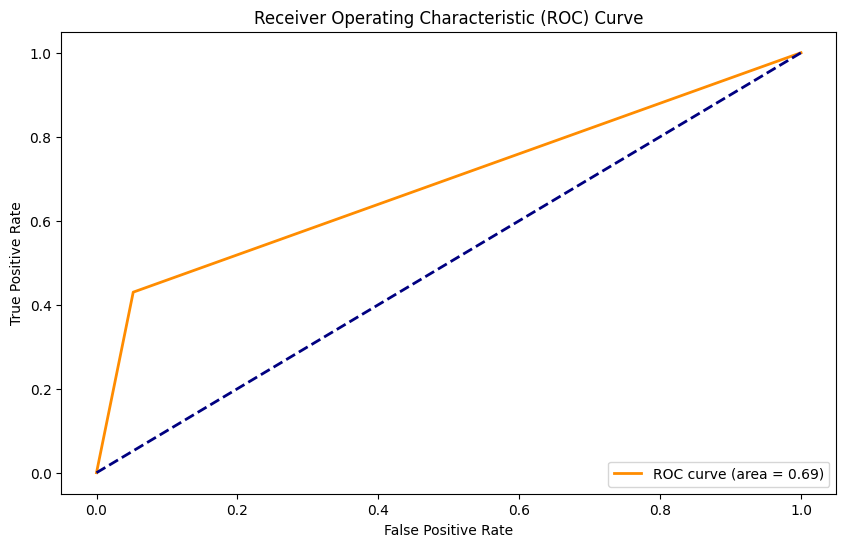

In [18]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## KNN con SMOTE

In [19]:
# Create a kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='uniform')

# Train the classifier on the training data
knn_classifier.fit(X_train_smote, y_train_smote)

# Make predictions on the testing data
y_pred = knn_classifier.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

Accuracy: 0.82
Precision: 0.39
Recall: 0.71
F1 Score: 0.50
AUC: 0.77


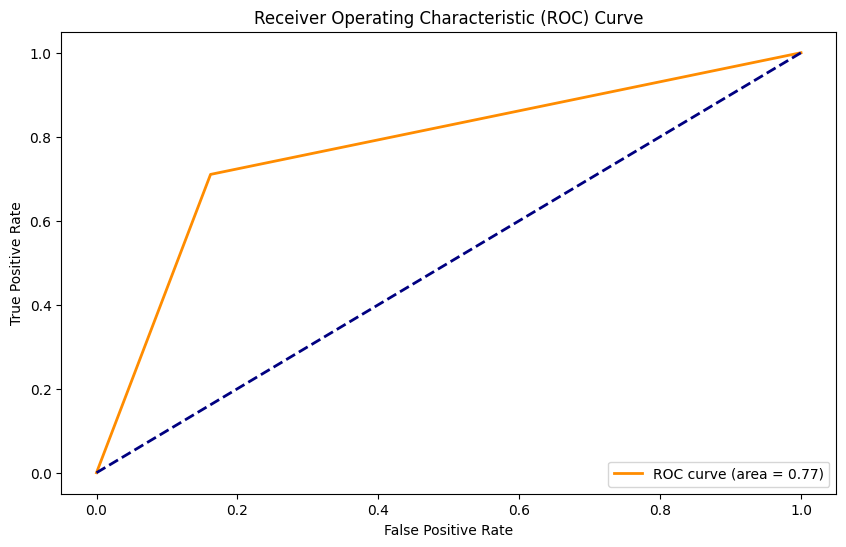

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Ridge Classifier

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import make_scorer, f1_score

# Define the Ridge classifier
ridge_classifier = RidgeClassifier()

# Define the hyperparameters and their possible values
param_grid = {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# Create a F1 scorer for grid search
f1_scorer = make_scorer(f1_score)

# Create GridSearchCV object
grid_search = GridSearchCV(ridge_classifier, param_grid, scoring=f1_scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_ridge_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_ridge_model.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

# Calculate F1 Score on the test set
f1score = f1_score(y_test, y_pred)
print(f'F1 Score on Test Set: {f1score:.2f}')

Best Hyperparameters: {'alpha': 0.1, 'solver': 'auto'}
F1 Score on Test Set: 0.19


Accuracy: 0.87
Precision: 0.42
Recall: 0.12
F1 Score: 0.19
AUC: 0.55


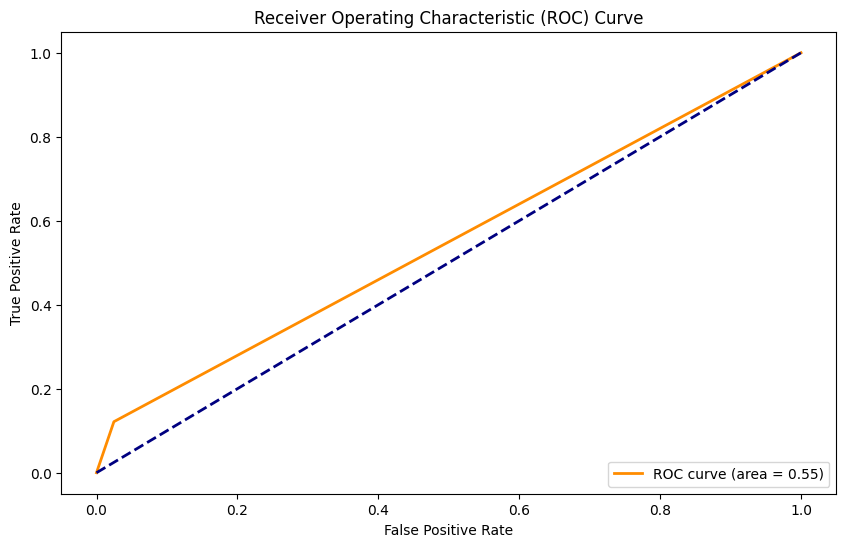

In [16]:
ridge_classifier = RidgeClassifier(alpha = 0.1, solver = 'auto')

# Train the classifier on the training data
ridge_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = ridge_classifier.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Ridge Classifier con SMOTE

Accuracy: 0.78
Precision: 0.33
Recall: 0.65
F1 Score: 0.44
AUC: 0.73


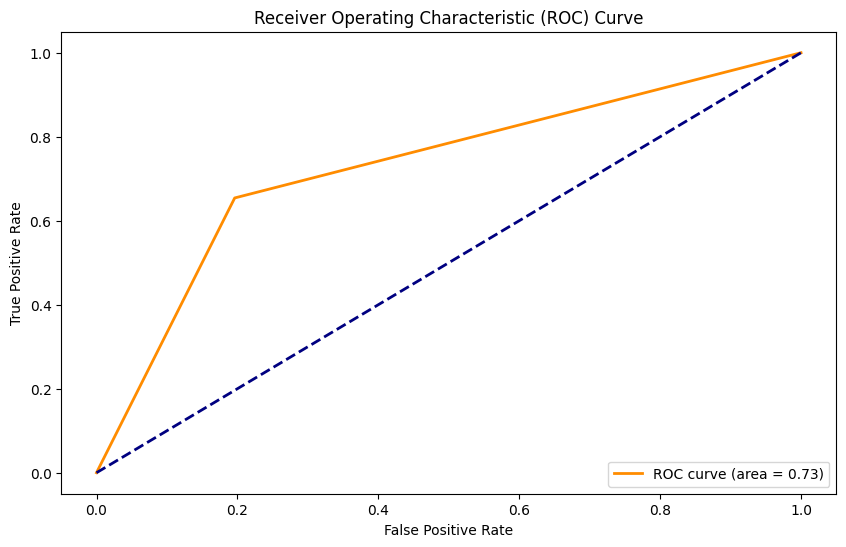

In [22]:
ridge_classifier = RidgeClassifier(alpha = 0.1, solver = 'auto')

# Train the classifier on the training data
ridge_classifier.fit(X_train_smote, y_train_smote)

# Make predictions on the testing data
y_pred = ridge_classifier.predict(X_test)
y_pred = (y_pred[:, 1] > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import MultinomialNB

# Define the Naive Bayes model
naive_bayes = MultinomialNB()

# Define the parameter grid to search
param_grid = {
    'alpha': np.linspace(0.1, 1.0, 10),  # Adjust as needed
    'fit_prior': [True, False]
}

# Create F1 scorer
f1_scorer = make_scorer(f1_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(naive_bayes, param_grid, cv=5, scoring=f1_scorer)

# Fit the grid search to the data
grid_search.fit(X_train, y_train[:, 1].astype(int))

# Print the best parameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Hyperparameters: {'alpha': 0.1, 'fit_prior': True}
Best F1 Score: 0.43899155529615747


Accuracy: 0.79
Precision: 0.33
Recall: 0.65
F1 Score: 0.44
AUC: 0.73


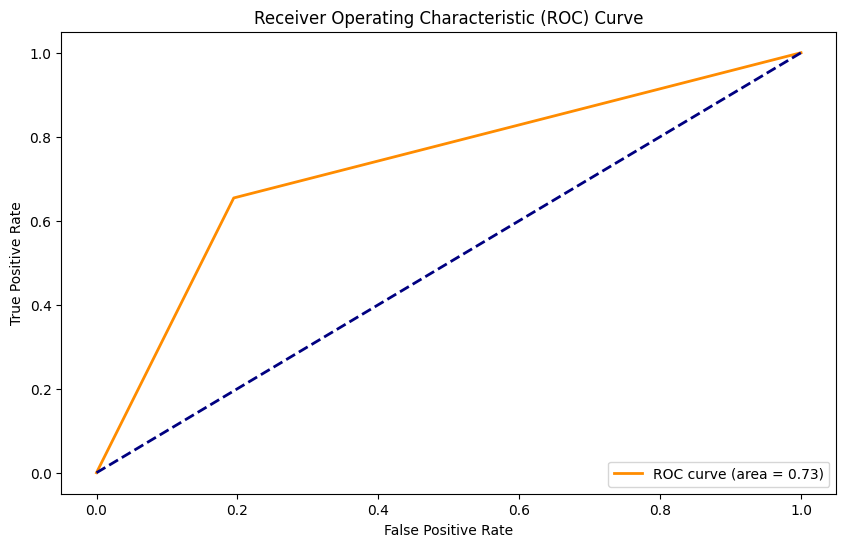

In [38]:
# Create a kNN classifier with k=3
naive_bayes = MultinomialNB(alpha=0.1, fit_prior=True)

# Train the classifier on the training data
naive_bayes.fit(X_train, y_train[:, 1].astype(int))

# Make predictions on the testing data
y_pred = naive_bayes.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Naiva Bayes Classifier con SMOTE

Accuracy: 0.79
Precision: 0.35
Recall: 0.71
F1 Score: 0.47
AUC: 0.76


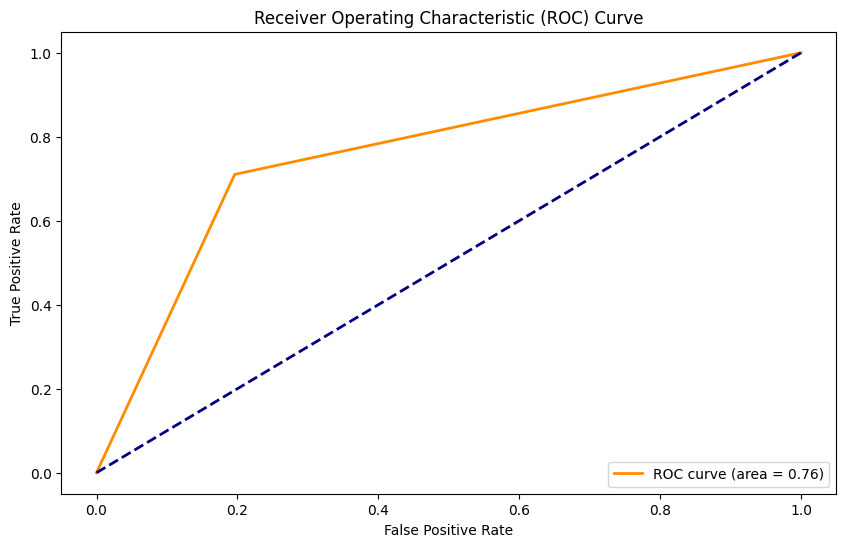

In [39]:
# Create a kNN classifier with k=3
naive_bayes = MultinomialNB(alpha=0.1, fit_prior=True)

# Train the classifier on the training data
naive_bayes.fit(X_train_smote, y_train_smote[:, 1].astype(int))

# Make predictions on the testing data
y_pred = naive_bayes.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Define the Random Forest model
rf_model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Create F1 scorer
f1_scorer = make_scorer(f1_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=f1_scorer)

# Fit the grid search to the data
grid_search.fit(X_train, y_train[:, 1].astype(int))

# Print the best parameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Hyperparameters: {'class_weight': None, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Score: 0.6555674195944813


Accuracy: 0.93
Precision: 0.87
Recall: 0.51
F1 Score: 0.65
AUC: 0.75


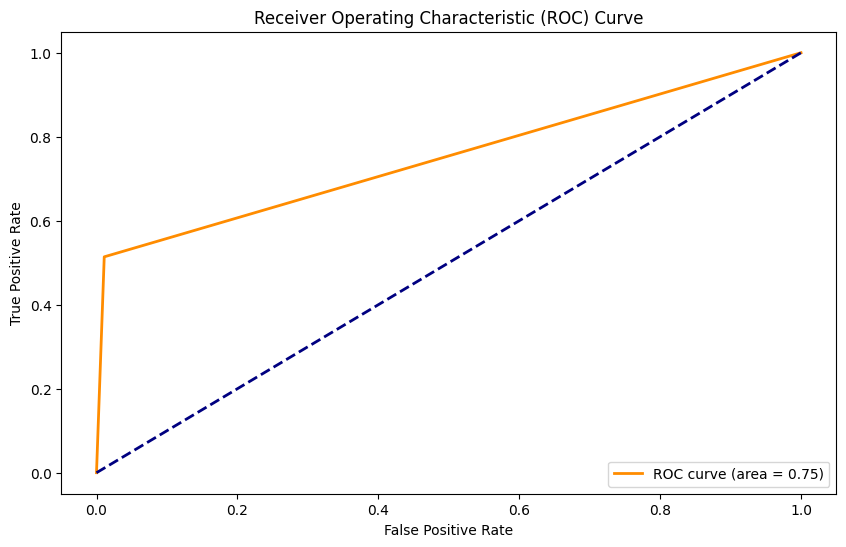

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(n_estimators=200,
                                  max_depth=7,
                                  min_samples_leaf = 1,
                                  min_samples_split = 5,
                                  class_weight = None)

# Train the classifier on the training data
rf_model.fit(X_train, y_train[:, 1].astype(int))

# Make predictions on the testing data
y_pred_rf = rf_model.predict(X_test)

# Get unique values in the array
unique_values = np.unique(y_pred_rf)
# Initialize one-hot encoded array with zeros
y_pred = np.zeros((len(y_pred_rf), len(unique_values)))
# Fill in the one-hot array based on the original binary array
for i, value in enumerate(y_pred_rf):
    y_pred[i, np.where(unique_values == value)] = 1

# Calculate accuracy
accuracy = accuracy_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier con SMOTE

Accuracy: 0.86
Precision: 0.48
Recall: 0.80
F1 Score: 0.60
AUC: 0.84


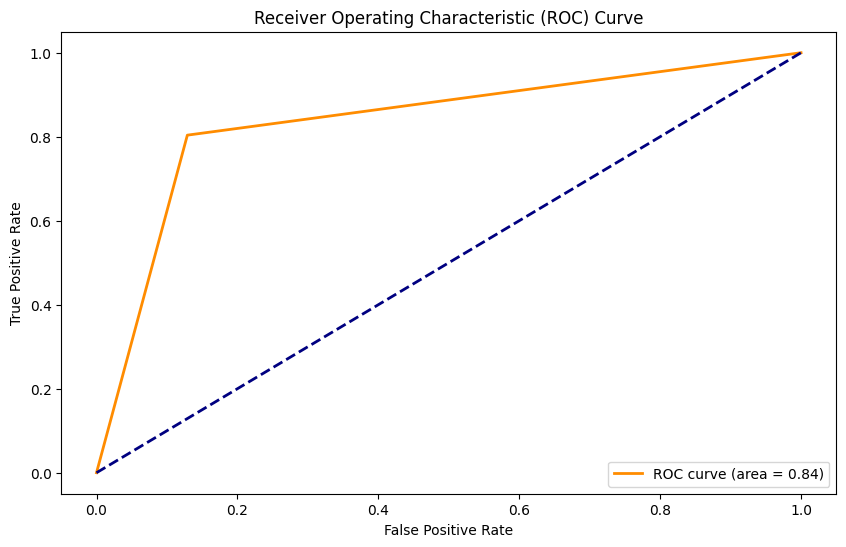

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(n_estimators=200,
                                  max_depth=7,
                                  min_samples_leaf = 1,
                                  min_samples_split = 5,
                                  class_weight = None)

# Train the classifier on the training data
rf_model.fit(X_train_smote, y_train_smote[:, 1].astype(int))

# Make predictions on the testing data
y_pred_rf = rf_model.predict(X_test)

# Get unique values in the array
unique_values = np.unique(y_pred_rf)
# Initialize one-hot encoded array with zeros
y_pred = np.zeros((len(y_pred_rf), len(unique_values)))
# Fill in the one-hot array based on the original binary array
for i, value in enumerate(y_pred_rf):
    y_pred[i, np.where(unique_values == value)] = 1

# Calculate accuracy
accuracy = accuracy_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test[:, 1].astype(int), np.argmax(y_pred, axis=1))
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Nueva propuesta: Stacked model

In [33]:
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.neighbors import KNeighborsClassifier

X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

################## LSTM ##################

# matriz de 9363 x 20
embedding_matrix = np.zeros((len(d2v_model.wv.index_to_key)+ 1, 20))

model = Sequential()

model.add(Embedding(len(d2v_model.wv.index_to_key)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

model.add(LSTM(50,return_sequences=False))

model.add(Dense(2,activation="softmax"))

model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics = ['accuracy'])

batch_size = 32

history = model.fit(X_train, y_train, epochs =50, batch_size=batch_size, verbose = 2)

################## KNN ############################

# Create a kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='uniform')

# Train the classifier on the training data
knn_classifier.fit(X_train, y_train)

Epoch 1/50
119/119 - 6s - loss: 0.3772 - accuracy: 0.8738 - 6s/epoch - 49ms/step
Epoch 2/50
119/119 - 3s - loss: 0.0801 - accuracy: 0.9810 - 3s/epoch - 27ms/step
Epoch 3/50
119/119 - 3s - loss: 0.0316 - accuracy: 0.9916 - 3s/epoch - 27ms/step
Epoch 4/50
119/119 - 3s - loss: 0.0154 - accuracy: 0.9968 - 3s/epoch - 27ms/step
Epoch 5/50
119/119 - 3s - loss: 0.0098 - accuracy: 0.9974 - 3s/epoch - 26ms/step
Epoch 6/50
119/119 - 3s - loss: 0.0054 - accuracy: 0.9987 - 3s/epoch - 25ms/step
Epoch 7/50
119/119 - 3s - loss: 0.0042 - accuracy: 0.9989 - 3s/epoch - 25ms/step
Epoch 8/50
119/119 - 3s - loss: 0.0041 - accuracy: 0.9992 - 3s/epoch - 25ms/step
Epoch 9/50
119/119 - 3s - loss: 0.0028 - accuracy: 0.9995 - 3s/epoch - 23ms/step
Epoch 10/50
119/119 - 3s - loss: 0.0013 - accuracy: 0.9997 - 3s/epoch - 23ms/step
Epoch 11/50
119/119 - 3s - loss: 0.0014 - accuracy: 0.9997 - 3s/epoch - 23ms/step
Epoch 12/50
119/119 - 3s - loss: 9.4009e-04 - accuracy: 0.9997 - 3s/epoch - 23ms/step
Epoch 13/50
119/119 -

KNeighborsClassifier(n_neighbors=3)

In [34]:
from sklearn.linear_model import LogisticRegression

# Hacer predicciones en el conjunto de validación
pred1 = model.predict(X_valid)

pred2 = knn_classifier.predict(X_valid)

# Stack predicciones para crear nuevas características para el meta-modelo
stacked_predictions = np.column_stack((pred1, pred2))

# Entrenar el meta-modelo
meta_model = LogisticRegression()

y_valid_onehot = y_valid[:, 1].astype(int)

meta_model.fit(stacked_predictions, y_valid_onehot)

# Para hacer predicciones en nuevos datos
new_pred1 = model.predict(X_test)

new_pred2 = knn_classifier.predict(X_test)

stacked_new_predictions = np.column_stack((new_pred1, new_pred2))

final_predictions = meta_model.predict(stacked_new_predictions)

27/27 [==============================] - 0s 10ms/step


Accuracy: 0.99
Precision: 0.98
Recall: 0.93
F1 Score: 0.95
AUC: 0.96


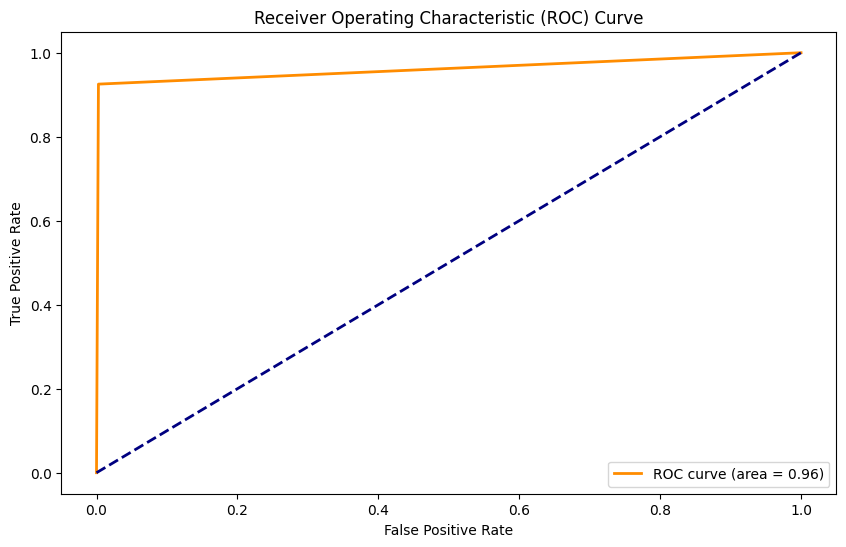

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

# Calcular y mostrar la precisión
Y_test_onehot = y_test[:, 1].astype(int)

# Calculate accuracy
accuracy = accuracy_score(Y_test_onehot, final_predictions)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(Y_test_onehot, final_predictions)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(Y_test_onehot, final_predictions)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(Y_test_onehot, final_predictions)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test_onehot, final_predictions)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Stacked Model con SMOTE

27/27 [==============================] - 0s 9ms/step
Accuracy: 0.91
Precision: 0.59
Recall: 0.96
F1 Score: 0.73
AUC: 0.93


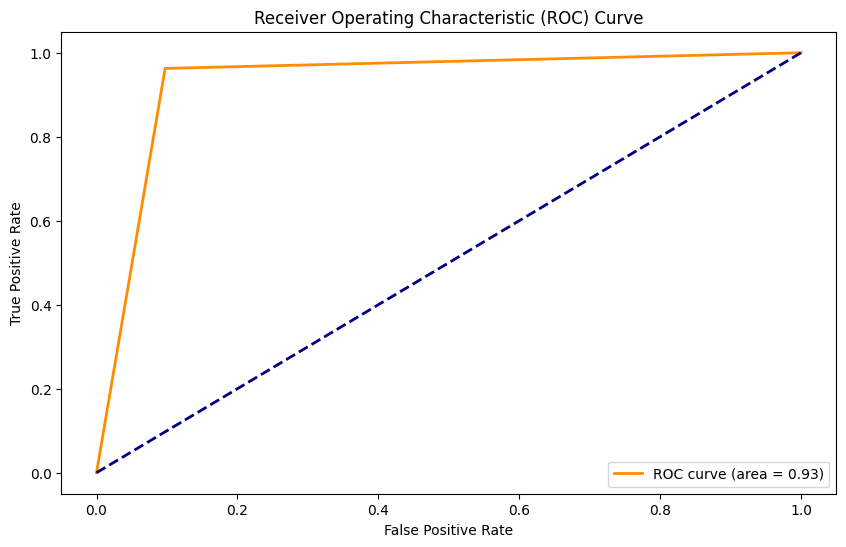

In [37]:
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.neighbors import KNeighborsClassifier

X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

################## SMOTE #################

from imblearn.over_sampling import SMOTE

# Crear una instancia de SMOTE
smote = SMOTE(random_state=42)

y_for_smote = np.argmax(y_train, axis=1)

# Aplicar SMOTE al conjunto de entrenamiento
X_train_smote, y_for_smote = smote.fit_resample(X_train, y_train)

# Get unique values in the array
unique_values = np.unique(y_for_smote)

# Initialize one-hot encoded array with zeros
y_train_smote = np.zeros((len(y_for_smote), len(unique_values)))

# Fill in the one-hot array based on the original binary array
for i, value in enumerate(y_for_smote):

    y_train_smote[i, np.where(unique_values == value)] = 1

################## LSTM ##################

# matriz de 9363 x 20
embedding_matrix = np.zeros((len(d2v_model.wv.index_to_key)+ 1, 20))

model = Sequential()

model.add(Embedding(len(d2v_model.wv.index_to_key)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

model.add(LSTM(50,return_sequences=False))

model.add(Dense(2,activation="softmax"))

model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics = ['accuracy'])

batch_size = 32

history = model.fit(X_train_smote, y_train_smote, epochs =50, batch_size=batch_size, verbose = 0)

################## KNN ############################

# Create a kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='uniform')

# Train the classifier on the training data
knn_classifier.fit(X_train_smote, y_train_smote)

from sklearn.linear_model import LogisticRegression

# Hacer predicciones en el conjunto de validación
pred1 = model.predict(X_valid)

pred2 = knn_classifier.predict(X_valid)

# Stack predicciones para crear nuevas características para el meta-modelo
stacked_predictions = np.column_stack((pred1, pred2))

# Entrenar el meta-modelo
meta_model = LogisticRegression()

y_valid_onehot = y_valid[:, 1].astype(int)

meta_model.fit(stacked_predictions, y_valid_onehot)

# Para hacer predicciones en nuevos datos
new_pred1 = model.predict(X_test)

new_pred2 = knn_classifier.predict(X_test)

stacked_new_predictions = np.column_stack((new_pred1, new_pred2))

final_predictions = meta_model.predict(stacked_new_predictions)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

# Calcular y mostrar la precisión
Y_test_onehot = y_test[:, 1].astype(int)

# Calculate accuracy
accuracy = accuracy_score(Y_test_onehot, final_predictions)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(Y_test_onehot, final_predictions)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(Y_test_onehot, final_predictions)
print(f'Recall: {recall:.2f}')

# Calculate F1 Score
f1score = f1_score(Y_test_onehot, final_predictions)
print(f'F1 Score: {f1score:.2f}')

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test_onehot, final_predictions)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f'AUC: {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Conclusiones

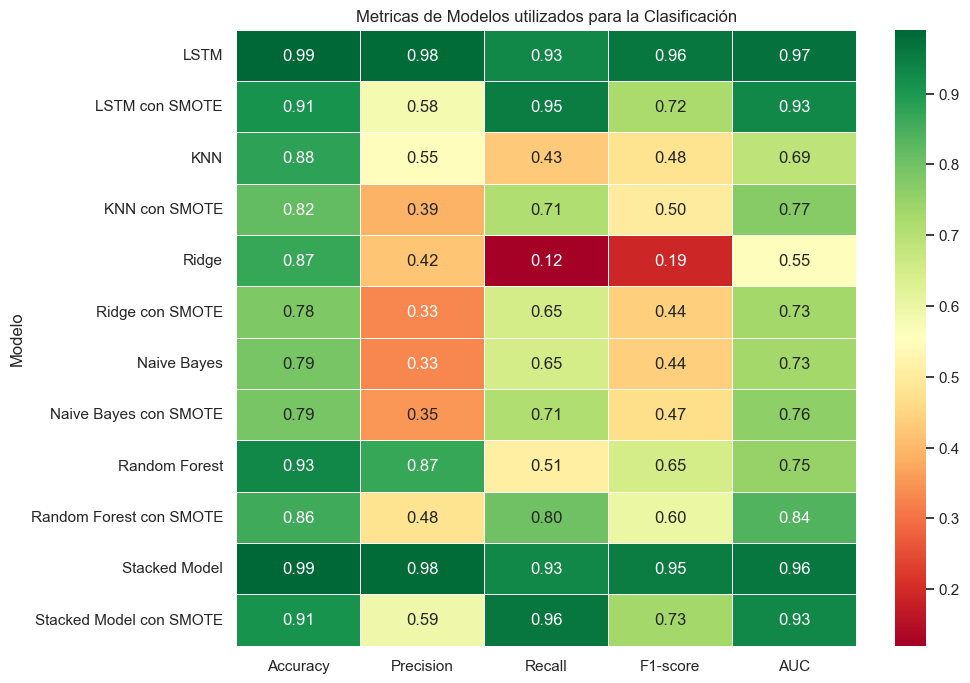

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el dataframe con los datos
data = {
    'Modelo': ['LSTM', 'LSTM con SMOTE', 'KNN', 'KNN con SMOTE', 'Ridge', 'Ridge con SMOTE',
               'Naive Bayes', 'Naive Bayes con SMOTE', 'Random Forest', 'Random Forest con SMOTE',
               'Stacked Model', 'Stacked Model con SMOTE'],
    'Accuracy': [0.99, 0.91, 0.88, 0.82, 0.87, 0.78, 0.79, 0.79, 0.93, 0.86, 0.99, 0.91],
    'Precision': [0.98, 0.58, 0.55, 0.39, 0.42, 0.33, 0.33, 0.35, 0.87, 0.48, 0.98, 0.59],
    'Recall': [0.93, 0.95, 0.43, 0.71, 0.12, 0.65, 0.65, 0.71, 0.51, 0.80, 0.93, 0.96],
    'F1-score': [0.96, 0.72, 0.48, 0.50, 0.19, 0.44, 0.44, 0.47, 0.65, 0.60, 0.95, 0.73],
    'AUC': [0.97, 0.93, 0.69, 0.77, 0.55, 0.73, 0.73, 0.76, 0.75, 0.84, 0.96, 0.93]
}

df = pd.DataFrame(data)

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
sns.heatmap(df.set_index('Modelo'), cmap='RdYlGn', annot=True, fmt=".2f", linewidths=.5)
plt.title('Metricas de Modelos utilizados para la Clasificación')
plt.show()